In [1]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import sys

from stardist.models import StarDist2D
from stardist import random_label_cmap
from csbdeep.utils import normalize

import torch
from torchvision import models
from torchvision.models.resnet import ResNet34_Weights
from torchvision import transforms

import pytorch_lightning as pl

from prodigyopt import Prodigy

In [2]:
# States:
np.random.seed(42)
lbl_cmap = random_label_cmap()

## Load data

In [3]:
# Import WSI images
img_array = np.load('data_old/images.npy')
img_array.shape

(4981, 256, 256, 3)

In [4]:
#Normalize input images and fill holes in masks
n_channel = 1 if img_array.ndim == 2 else img_array[0].shape[-1]  
axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

images_norm = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(img_array)]

Normalizing image channels jointly.


100%|██████████| 4981/4981 [00:09<00:00, 505.34it/s]


## Run predictions

In [5]:
#Load saved model
my_model = StarDist2D(None, name='NucleiSegmentor', basedir='models/')
model=my_model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.467853, nms_thresh=0.3.


In [6]:
#Predict on validation images
preds = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0] for x in tqdm(images_norm)]

100%|██████████| 4981/4981 [06:15<00:00, 13.25it/s]


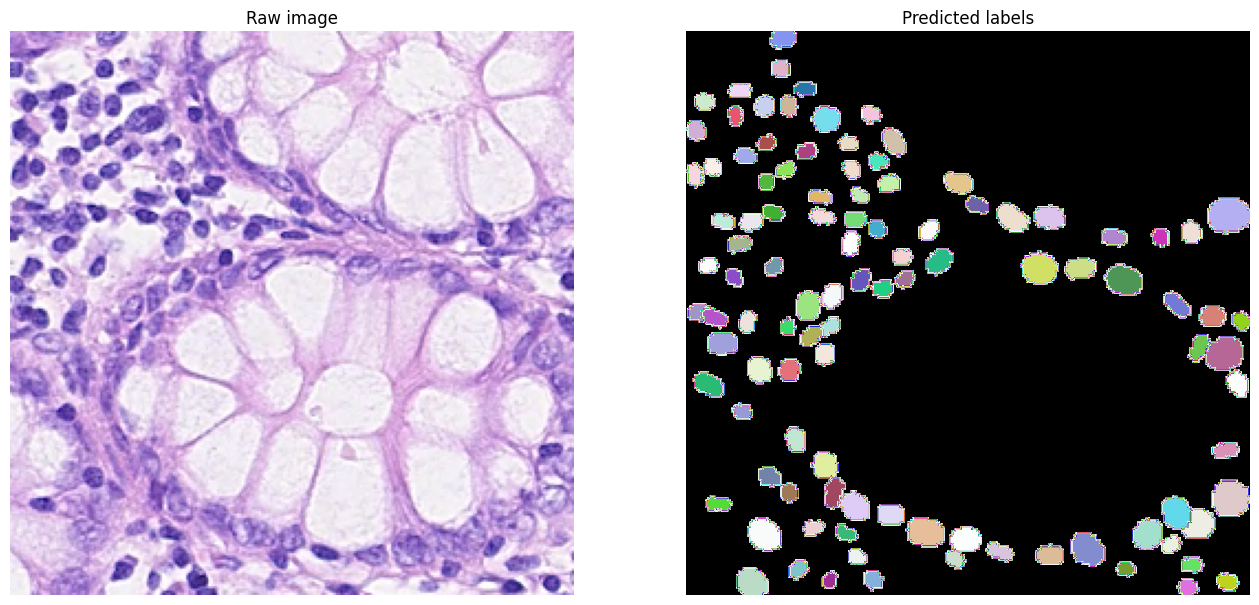

In [7]:
# Plot a few example images
i = 10
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img_array[i], cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(preds[i], cmap=lbl_cmap); plt.axis('off'); plt.title('Predicted labels')
plt.show()

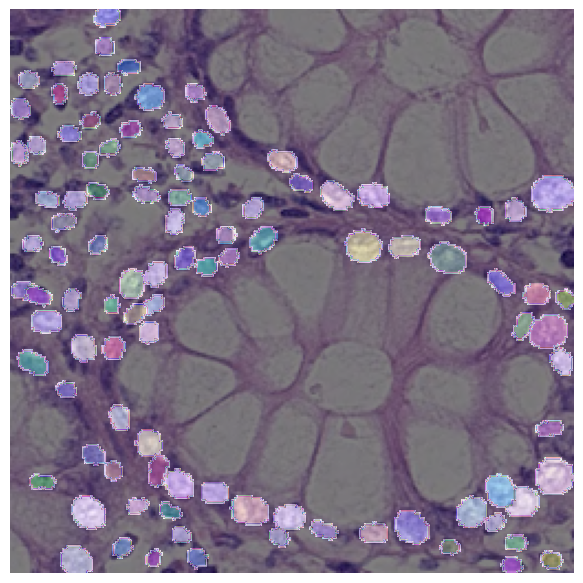

In [10]:
# Plot segmentation on top of raw image
i = 10
plt.figure(figsize=(16,10))
plt.subplot(122); plt.imshow(img_array[i], cmap='gray'); plt.imshow(preds[i], cmap=lbl_cmap, alpha=0.5); plt.axis('off')
plt.savefig('data_old/segmentaion.png')
plt.show()

## Extract patches

In [7]:
def extract_square_patches(segmentation_maps, images, margin=10, patch_size=(64, 64)):
    all_patches = []
    patch_info = []  # List to store information about each patch

    for i, (segmentation_map, image) in enumerate(zip(segmentation_maps, images)):
        for cell_id in np.unique(segmentation_map):
            if cell_id == 0:  # Skip background
                continue

            # Find the positions of the current cell
            positions = np.where(segmentation_map == cell_id)
            min_row, min_col = np.min(positions, axis=1)
            max_row, max_col = np.max(positions, axis=1)

            # Determine the size of the square bounding box
            box_size = max(max_row - min_row, max_col - min_col) + margin

            # Calculate the center of the bounding box
            center_row = (max_row + min_row) // 2
            center_col = (max_col + min_col) // 2

            # Determine new min and max rows and columns
            start_row = max(center_row - box_size // 2, 0)
            end_row = min(center_row + box_size // 2, segmentation_map.shape[0])
            start_col = max(center_col - box_size // 2, 0)
            end_col = min(center_col + box_size // 2, segmentation_map.shape[1])

            # Extract the patch from the image
            patch = image[start_row:end_row, start_col:end_col]

            # Prepare a mask for the current cell_id within the patch
            cell_mask = segmentation_map[start_row:end_row, start_col:end_col] == cell_id

            # Store the original segmentation map for the current cell
            original_segmentation_map = segmentation_map[start_row:end_row, start_col:end_col].copy()

            # Create a segmentation map for just the current cell, setting it to 1
            single_cell_segmentation_map = np.zeros_like(segmentation_map[start_row:end_row, start_col:end_col])
            single_cell_segmentation_map[cell_mask] = 1  # Set cell pixels to 1

            # Resize the patch to the desired size
            resized_patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_LINEAR)

            # Resize the single_cell_segmentation_map to the patch size
            resized_segmentation_map = cv2.resize(single_cell_segmentation_map.astype(np.float32), patch_size, interpolation=cv2.INTER_NEAREST).astype(np.uint8)

            # Store the patch and its corresponding information
            all_patches.append(resized_patch)
            patch_info.append({
                'image_index': i,  # Index of the original image
                'cell_id': cell_id,  # Identifier of the cell in the segmentation map
                'segmentation_map': resized_segmentation_map,  # Resized segmentation map portion for the patch
                'original_segmentation_map': original_segmentation_map,  # Original scale segmentation map
                'tl_corner': (start_col, start_row),  # Top-left corner of the patch in the original image
                'patch_size': (end_col - start_col, end_row - start_row),  # Original Width and Height of the patch before resize
                'is_neutrophil': None  # Placeholder for classification result
            })

    return np.array(all_patches), patch_info

In [8]:
# Get all patches and labels
patches, patch_info = extract_square_patches(preds, img_array)

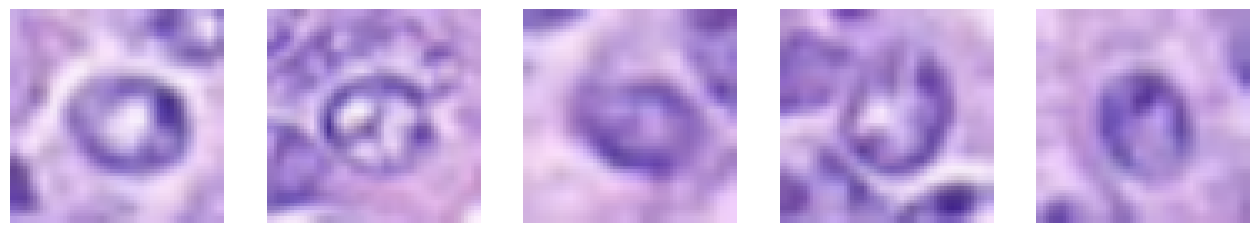

In [9]:
# plot a few patches
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patches[i], cmap='gray')
    plt.axis('off')
plt.show()

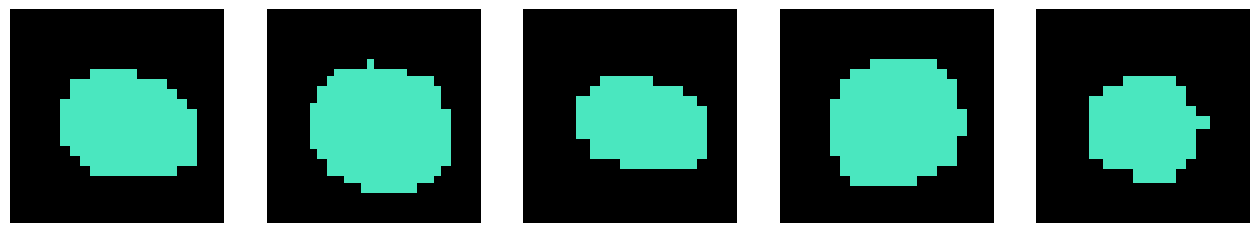

In [10]:
# Plot a few segmentation maps
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patch_info[i]['segmentation_map'], cmap=lbl_cmap)
    plt.axis('off')
plt.show()

In [11]:
# Amount of patches
print("Amount of patches:", len(patches))

Amount of patches: 544866


## Run classification

In [12]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes, pos_weight=None):
        super().__init__()
        weights = ResNet34_Weights.IMAGENET1K_V1
        self.model = models.resnet34(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)
        # Set up the weighted BCE Loss
        if pos_weight is not None:
            pos_weight = torch.tensor([pos_weight])
            self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.criterion = torch.nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x).squeeze(1)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = Prodigy(self.parameters(), lr=1.)
        return optimizer

In [14]:
# Load the model
num_classes = 1
pos_weight_value = 1000
model = ImageClassifier(num_classes=num_classes, pos_weight=pos_weight_value)
model.load_state_dict(torch.load('models/neutrophil_classifier_best.pth'))
model.eval()

_utils.py (208): The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
_utils.py (223): Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
threshold = 0.5  # Define your threshold for classification

with torch.no_grad():
    for i, patch in enumerate(patches):
        # Convert the patch to a PyTorch tensor, normalize, add batch dimension, and transfer to the correct device
        patch_tensor = transforms.ToTensor()(patch).unsqueeze(0)
        patch_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(patch_tensor)

        # Predict
        output = model(patch_tensor)
        probability = torch.sigmoid(output)  # Apply sigmoid to convert output to probability
        pred = (probability > threshold).item()  # Convert probability to binary class based on the threshold

        # Update patch_info with the prediction
        patch_info[i]['is_neutrophil'] = pred

In [16]:
neutrophil = []
not_neutrophil = []

for patch in patch_info:
    if patch['is_neutrophil'] == 1:
        neutrophil.append(patch)
    else:
        not_neutrophil.append(patch)

# how many patches are classified as neutrophils
print("Neutrophils:", len(neutrophil))
print("Not Neutrophils:", len(not_neutrophil))

Neutrophils: 50914
Not Neutrophils: 493952


## Map to images

In [17]:
def reconstruct_segmentation_maps(images, patch_info):
    # Create a list of zeros arrays for each image
    full_segmentation_maps = [np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8) for image in images]

    # Iterate over each patch information and place it back to its original location
    for info in patch_info:
        if info['is_neutrophil']:  # Check if the patch is classified as neutrophil
            img_idx = info['image_index']  # Index of the original image
            tl_col, tl_row = info['tl_corner']  # Top-left corner coordinates
            orig_seg_map = info['original_segmentation_map']  # Use the original segmentation map

            # Calculate the exact position where the patch should be placed
            end_row = tl_row + orig_seg_map.shape[0]
            end_col = tl_col + orig_seg_map.shape[1]

            # Determine the overlapping area sizes
            overlap_height = min(end_row, full_segmentation_maps[img_idx].shape[0]) - tl_row
            overlap_width = min(end_col, full_segmentation_maps[img_idx].shape[1]) - tl_col

            # Place or blend the original segmentation map back into the full image's segmentation map
            full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width] = np.maximum(
                full_segmentation_maps[img_idx][tl_row:tl_row + overlap_height, tl_col:tl_col + overlap_width],
                orig_seg_map[:overlap_height, :overlap_width])

    return full_segmentation_maps

# Assuming `images` and `patch_info` are already defined
full_maps = reconstruct_segmentation_maps(img_array, patch_info)

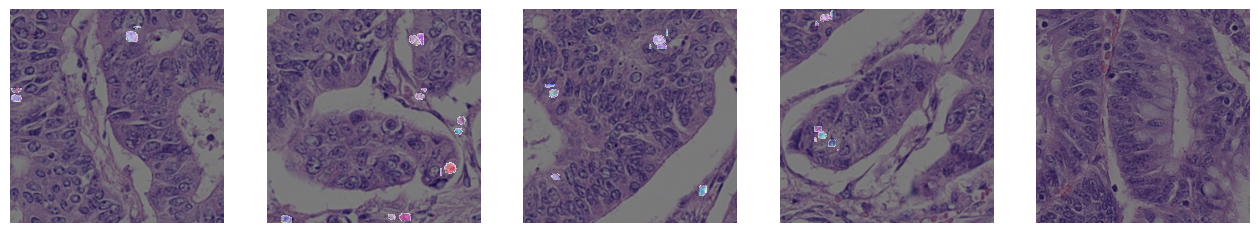

In [18]:
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(img_array[i])
    plt.imshow(full_maps[i], cmap=lbl_cmap, alpha=0.5)
    plt.axis('off')
plt.show()

In [24]:
def create_heatmaps(segmentation_maps, sigma=5):
    heatmaps = []
    epsilon = 1e-10 # Non zero devision
    for seg_map in segmentation_maps:
        heatmap = cv2.GaussianBlur(seg_map, (0, 0), sigma)
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + epsilon)
        heatmaps.append(heatmap)
    return heatmaps

# Create heatmaps
heatmaps = create_heatmaps(full_maps)

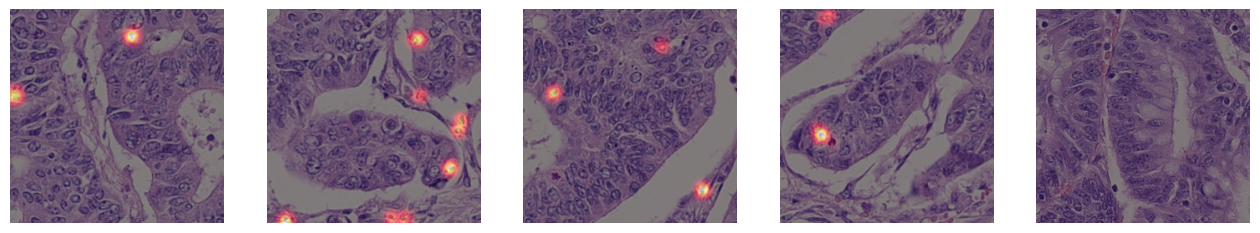

In [25]:
# Plot a few heatmaps on top of the original images
plt.figure(figsize=(16,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(img_array[i], cmap='gray')
    plt.imshow(heatmaps[i], cmap='hot', alpha=0.5)
    plt.axis('off')
plt.show()